In [16]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr   

# metpy
from metpy.plots import SkewT
from metpy.units import units


In [17]:
#catfn='/home/tmerlis/hackathon/xsh24_scream_main.yaml'

catfn='/home/tmerlis/hackathon/hackathon_cat_may14_main.yaml'

combo_cat = intake.open_catalog(catfn)

# 'coarse' is an online coarse-graining of 8 neighboring grid cells ~25km
# xsh24 = X-SHiELD 2024 model version, unpublished
# xsh21 = X-SHiELD 2021 model version, many articles including Cheng et al. 2022 GRL
print (list(combo_cat)) 

['xsh24_coarse', 'xsh24_native', 'xsh21_coarse', 'scream2D_hrly', 'scream_ne120', 'scream_lnd', 'ifs_fesom', 'icon_3hp003']


In [18]:
# select zoom level and the part of the combined catalog you're interested in
# coarse stores are available at zoom 7 ~50km and lower
zoom_select = 7
ds = combo_cat.xsh24_coarse(zoom=zoom_select).to_dask()
# attach coordinates; otherwise can't use lat and lon and selecting regions or taking a zonal mean won't work
ds = ds.pipe(egh.attach_coords)

# native stores are available at zoom 10 ~6.4km and lower, fewer variables and all are 2d
dsn = combo_cat.xsh24_native(zoom=9).to_dask()
dsn = dsn.pipe(egh.attach_coords)

# we downloaded output from DOE's SCREAM model to stellar
# conceivably, we could add to our local collection of models during the week
# or augment the catalog with observational datasets
ds_scream = combo_cat.scream_ne120(zoom=zoom_select).to_dask()
ds_scream = ds_scream.pipe(egh.attach_coords)

# only have zoom 7
ds_ifs = combo_cat.ifs_fesom().to_dask()
ds_ifs = ds_ifs.pipe(egh.attach_coords)


# have zoom 7 and 6 but 6 looked cold
ds_icon = combo_cat.icon_3hp003(zoom=7,time_method='mean').to_dask()
ds_icon  = ds_icon.pipe(egh.attach_coords)

/home/tmerlis/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/tmerlis/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/tmerlis/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mappi

In [19]:
# take a look at what variables are healpix-ified
# there are many more diagnostic variables that weren't part of the data request
ds_icon

<xarray.Dataset> Size: 98GB
Dimensions:        (time: 425, cell: 196608, pressure: 30, soil_level: 5,
                    pressure_rva: 3)
Coordinates:
  * pressure       (pressure) int64 240B 5 10 20 50 ... 92500 95000 97500 100000
  * pressure_rva   (pressure_rva) int64 24B 16 18 23
  * soil_level     (soil_level) int64 40B 0 0 0 2 6
  * time           (time) datetime64[ns] 3kB 2020-01-02 ... 2021-03-01
    crs            int64 8B 0
  * cell           (cell) int64 2MB 0 1 2 3 4 ... 196604 196605 196606 196607
    lat            (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.2984
    lon            (cell) float64 2MB 45.0 45.35 44.65 ... 315.4 314.6 315.0
Data variables: (12/58)
    clivi          (time, cell) float32 334MB dask.array<chunksize=(5, 196608), meta=np.ndarray>
    clt            (time, cell) float32 334MB dask.array<chunksize=(5, 196608), meta=np.ndarray>
    clwvi          (time, cell) float32 334MB dask.array<chunksize=(5, 196608), meta=np.ndarray>
    egpvi          (time, cell) float32 334MB dask.array<chunksize=(5, 196608), meta=np.ndarray>
    einvi          (time, cell) float32 334MB dask.array<chunksize=(5, 196608), meta=np.ndarray>
    ekhvi          (time, cell) float32 334MB dask.array<chunksize=(5, 196608), meta=np.ndarray>
    ...             ...
    ua             (time, pressure, cell) float32 10GB dask.array<chunksize=(5, 1, 196608), meta=np.ndarray>
    uas            (time, cell) float32 334MB dask.array<chunksize=(5, 196608), meta=np.ndarray>
    va             (time, pressure, cell) float32 10GB dask.array<chunksize=(5, 1, 196608), meta=np.ndarray>
    vas            (time, cell) float32 334MB dask.array<chunksize=(5, 196608), meta=np.ndarray>
    wa             (time, pressure, cell) float32 10GB dask.array<chunksize=(5, 1, 196608), meta=np.ndarray>
    zg             (time, pressure, cell) float32 10GB dask.array<chunksize=(5, 1, 196608), meta=np.ndarray>

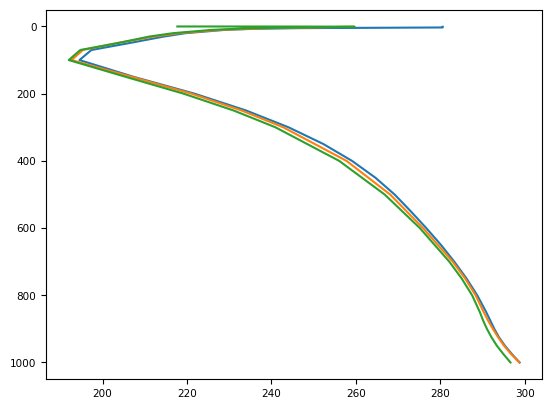

In [20]:
plt.plot(  ds['ta'].sel(time=slice('2020-01-01', '2020-01-31')).mean(dim='time').where(abs(ds.lat)<20).mean('cell'), ds.plev )
plt.plot(  ds_ifs['ta'].sel(time=slice('2020-01-01', '2020-01-31')).mean(dim='time').where(abs(ds.lat)<20).mean('cell'), ds_ifs.level )
plt.plot(  ds_icon['ta'].sel(time=slice('2020-01-01', '2020-01-31')).mean(dim='time').where(abs(ds.lat)<20).mean('cell'), ds_icon.pressure/100 )
plt.gca().invert_yaxis()

In [21]:

end_date = '2020-01-05'
T_scream2 = ds_scream['ta'].where(ds_scream['ta']>0).sel(time=slice('2020-01-01', end_date)).mean(dim='time').where(abs(ds.lat)<20).mean('cell').values * units.K
T_scream0 = ds_scream['ta'].sel(time=slice('2020-01-01', end_date)).mean(dim='time').where(abs(ds.lat)<20).mean('cell').values * units.K


In [22]:
T_scream2

Magnitude,[nan 239.6762237548828 224.8771209716797 215.18878173828125 209.73699951171875 200.70240783691406 192.5689697265625 193.497314453125 207.50003051757812 221.0470733642578 232.84799194335938 242.70680236816406 257.3188781738281 267.4266662597656 275.8014221191406 283.1211242675781 286.417724609375 289.17047119140625 290.8631896972656 290.82537841796875 290.9422607421875 291.2235107421875 290.70416259765625 289.62493896484375 289.98089599609375]
Units,kelvin


In [23]:
T_scream0

Magnitude,[0.0 239.6762237548828 224.8771209716797 215.18878173828125 209.73699951171875 200.70240783691406 192.5689697265625 193.497314453125 207.50003051757812 221.0470733642578 232.84799194335938 242.70680236816406 257.3188781738281 267.4266662597656 275.8014221191406 282.8836669921875 286.0827941894531 288.729736328125 290.2033386230469 289.5788879394531 286.202880859375 283.8951721191406 278.1164245605469 263.90692138671875 241.83062744140625]
Units,kelvin


<unknown>:64: SyntaxWarning: invalid escape sequence '\D'


CPU times: user 5min 3s, sys: 58.5 s, total: 6min 2s
Wall time: 4min 29s


[Text(0, 1.0, ''),
 Text(0, 10.0, ''),
 Text(0, 100.0, ''),
 Text(0, 1000.0, ''),
 Text(0, 10000.0, '')]

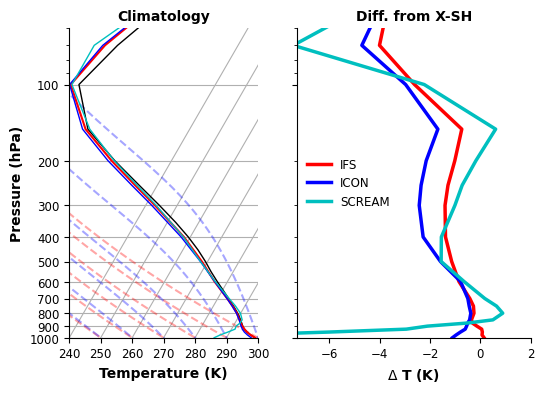

In [24]:
%%time 
fig = plt.figure(0, figsize=(6.5, 6.5/1.618))
tickfontsize = 7.5
smfontsize = 8.5
lgfontsize = 10
plt.rc('font',size=tickfontsize)


plt.subplots_adjust(hspace=0.3,wspace=0.15)

end_date = '2020-12-31'
p_xsh = ds.plev.values * units.hPa
T_xsh = ds['ta'].sel(time=slice('2020-01-01', end_date)).mean(dim='time').where(abs(ds.lat)<20).mean('cell').values * units.K

T_ifs = ds_ifs['ta'].sel(time=slice('2020-01-01', end_date)).mean(dim='time').where(abs(ds.lat)<20).mean('cell').values * units.K
p_ifs = ds_ifs.level.values * units.hPa

T_icon =  ds_icon['ta'].sel(time=slice('2020-01-01', end_date)).mean(dim='time').where(abs(ds.lat)<20).mean('cell').values * units.K
p_icon = ds_icon.pressure.values/100 * units.hPa

p_scream = ds_scream.lev.values * units.hPa
T_scream = ds_scream['ta'].where(ds_scream['ta']>0).sel(time=slice('2020-01-01', end_date)).mean(dim='time').where(abs(ds.lat)<20).mean('cell').values * units.K


#plt.gca().invert_yaxis()

skew = SkewT(fig,rect=[.1, .110, .47 ,.77])
skew.plot(p_xsh, T_xsh, 'k-',linewidth=1,label='X-SH24')
skew.plot(p_ifs, T_ifs, 'r-',linewidth=1.5,label='IFS')
skew.plot(p_icon, T_icon, 'b-',linewidth=1,label='ICON')

skew.plot(p_scream, T_scream, 'c-',linewidth=1,label='SCREAM')
skew.plot_dry_adiabats(t0=np.arange(240,310,10)* units.K,alpha=0.35)
skew.plot_moist_adiabats(t0=np.arange(240,310,10)* units.K,alpha=0.35)
skew.ax.set_ylim(1000, 60)
skew.ax.set_xlim(240-273.15, 300-273.15)

skew.ax.set_xlabel('Temperature (K)',fontsize=lgfontsize,fontweight='bold')
skew.ax.set_ylabel('Pressure (hPa)',fontsize=lgfontsize,fontweight='bold')

skew.ax.spines['top'].set_visible(False)
skew.ax.spines['right'].set_visible(False)
skew.ax.set_yticks(np.arange(100,1100,100))
skew.ax.tick_params(axis='both',labelsize=smfontsize)
skew.ax.set_title('Climatology',fontsize=lgfontsize,fontweight='bold')
skew.ax.set_xticks(np.arange(240,310,10)-273.15)
skew.ax.set_xticklabels(['240','250','260','270','280','290','300'])

#-----------------------
# difference panel
#-----------------------
ax = fig.add_subplot(122)
T_xshi = np.interp(p_ifs, p_xsh, T_xsh)
T_iconi = np.interp(p_ifs, p_icon, T_icon)

plt.semilogy(T_ifs - T_xshi,p_ifs,'r-',linewidth=2.5,label='IFS')

plt.semilogy(T_iconi - T_xshi,p_ifs,'b-',linewidth=2.5,label='ICON')

plt.semilogy(T_scream - T_xshi,p_ifs,'c-',linewidth=2.5,label='SCREAM')
#plt.semilogy(temp_ann[1,:]-T_era5_2021[cmip_plev_inds_for_era5],plev,'r--',linewidth=2.5,label='X-SHiELD 2021')
#plt.semilogy(ta_cmip6_ensmean.values-T_era5_amip.values[cmip_plev_inds_for_era5],plev_cmip/100,'k',linewidth=2.5,label='CMIP6 mean')
    
ax = plt.gca()
ax.set_xlabel('$\Delta$ T (K)',fontsize=lgfontsize,fontweight='bold')
ax.set_ylim([60, 1000])
ax.invert_yaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both',labelsize=smfontsize)
plt.legend(frameon=False,fontsize=smfontsize)
ax.set_ylabel('')
ax.set_xticks(np.arange(-6,4,2))
ax.set_xlim([-7.3, 2])
plt.title('Diff. from X-SH',fontsize=lgfontsize,fontweight='bold')
ax.set_yticklabels([])


In [ ]:
%%time 
fig = plt.figure(0, figsize=(6.5, 6.5/1.618))
tickfontsize = 7.5
smfontsize = 8.5
lgfontsize = 10
plt.rc('font',size=tickfontsize)


plt.subplots_adjust(hspace=0.3,wspace=0.15)

end_date = '2020-03-31'
#end_date = '2020-01-15'
p_xsh = ds.plev.values * units.hPa
T_xsh = ds['ta'].sel(time=slice('2020-01-01', end_date)).mean(dim='time').where(ds.lat>60).mean('cell').values * units.K

T_ifs = ds_ifs['ta'].sel(time=slice('2020-01-01', end_date)).mean(dim='time').where(ds.lat>60).mean('cell').values * units.K
p_ifs = ds_ifs.level.values * units.hPa

T_icon =  ds_icon['ta'].sel(time=slice('2020-01-01', end_date)).mean(dim='time').where(ds.lat>60).mean('cell').values * units.K
p_icon = ds_icon.pressure.values/100 * units.hPa

p_scream = ds_scream.lev.values * units.hPa
T_scream = ds_scream['ta'].where(ds_scream['ta']>0).sel(time=slice('2020-01-01', end_date)).mean(dim='time').where(ds.lat>60).mean('cell').values * units.K


#plt.gca().invert_yaxis()

skew = SkewT(fig,rect=[.1, .110, .47 ,.77])
skew.plot(p_xsh, T_xsh, 'k-',linewidth=1,label='X-SH24')
skew.plot(p_ifs, T_ifs, 'r-',linewidth=1.5,label='IFS')
skew.plot(p_icon, T_icon, 'b-',linewidth=1,label='ICON')

skew.plot(p_scream, T_scream, 'c-',linewidth=1,label='SCREAM')
skew.plot_dry_adiabats(t0=np.arange(240,310,10)* units.K,alpha=0.35)
skew.plot_moist_adiabats(t0=np.arange(240,310,10)* units.K,alpha=0.35)
skew.ax.set_ylim(1000, 60)
#skew.ax.set_xlim(240-273.15, 300-273.15)
skew.ax.set_xlim(235-273.15, 270-273.15)

skew.ax.set_xlabel('JFM Arctic T (K)',fontsize=lgfontsize,fontweight='bold')
skew.ax.set_ylabel('Pressure (hPa)',fontsize=lgfontsize,fontweight='bold')

skew.ax.spines['top'].set_visible(False)
skew.ax.spines['right'].set_visible(False)
skew.ax.set_yticks(np.arange(100,1100,100))
skew.ax.tick_params(axis='both',labelsize=smfontsize)
skew.ax.set_title('Climatology',fontsize=lgfontsize,fontweight='bold')
skew.ax.set_xticks(np.arange(235,275,5)-273.15)
#skew.ax.set_xticklabels(['235','240','245','250','255','260','265','270'])
skew.ax.set_xticklabels(['235','','245','','255','','265',''])

#-----------------------
# difference panel
#-----------------------
ax = fig.add_subplot(122)
T_xshi = np.interp(p_ifs, p_xsh, T_xsh)
T_iconi = np.interp(p_ifs, p_icon, T_icon)


plt.semilogy(T_xshi - T_xshi,p_ifs,'k:',linewidth=1)

plt.semilogy(T_ifs - T_xshi,p_ifs,'r-',linewidth=2.5,label='IFS')

plt.semilogy(T_iconi - T_xshi,p_ifs,'b-',linewidth=2.5,label='ICON')

plt.semilogy(T_scream - T_xshi,p_ifs,'c-',linewidth=2.5,label='SCREAM')
#plt.semilogy(temp_ann[1,:]-T_era5_2021[cmip_plev_inds_for_era5],plev,'r--',linewidth=2.5,label='X-SHiELD 2021')
#plt.semilogy(ta_cmip6_ensmean.values-T_era5_amip.values[cmip_plev_inds_for_era5],plev_cmip/100,'k',linewidth=2.5,label='CMIP6 mean')
    
ax = plt.gca()
ax.set_xlabel('$\Delta$ T (K)',fontsize=lgfontsize,fontweight='bold')
ax.set_ylim([60, 1000])
ax.invert_yaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both',labelsize=smfontsize)
plt.legend(frameon=False,fontsize=smfontsize)
ax.set_ylabel('')
ax.set_xticks(np.arange(-6,4,3))
ax.set_xlim([-7.2, 2.2])
plt.title('Diff. from X-SH',fontsize=lgfontsize,fontweight='bold')
ax.set_yticklabels([])


<unknown>:70: SyntaxWarning: invalid escape sequence '\D'
